<h1> Stanford Dogs

In [1]:
#from stanford_dogs_utils import *
import numpy as np #1.21.3works with opencv
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import timeit
import os
import pickle

from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
from tensorflow.keras.models import load_model

In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


# Images preprocessing

## Quick overview of data

In [2]:
annotations_dir = './annotation/Annotation/'
images_dir = './images/Images'

In [3]:
# Define path to data
#annotations_dir = './Dogs/Annotation' 
#images_dir = './Dogs/Images'

In [4]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

FileNotFoundError: [Errno 2] No such file or directory: './images/Images'

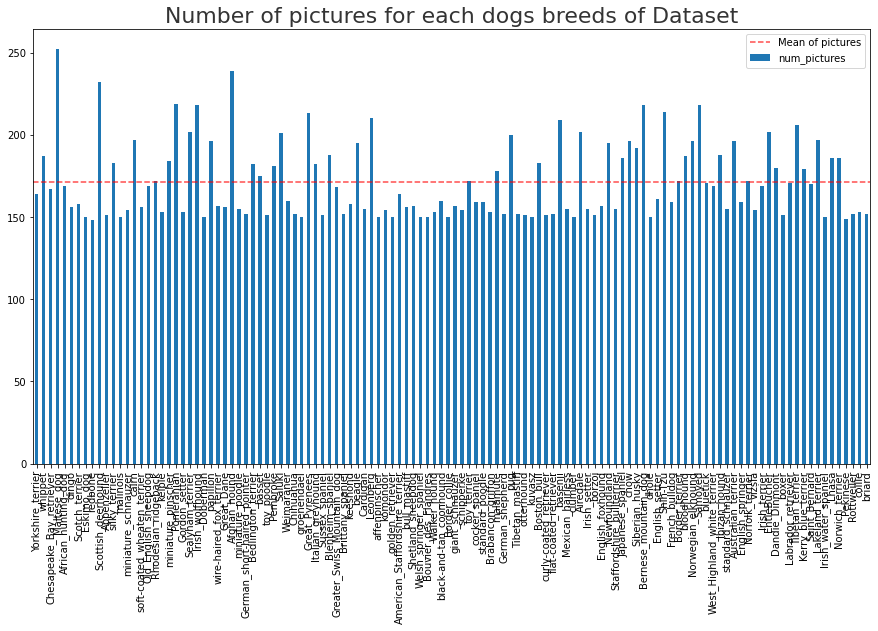

In [7]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(15,8))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

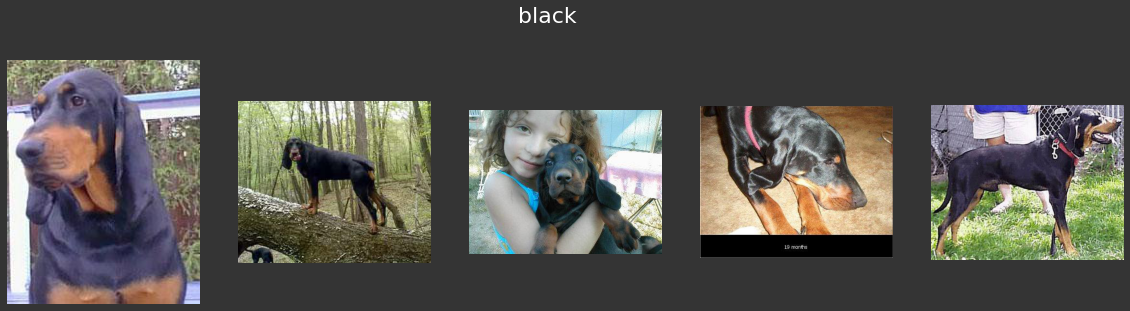

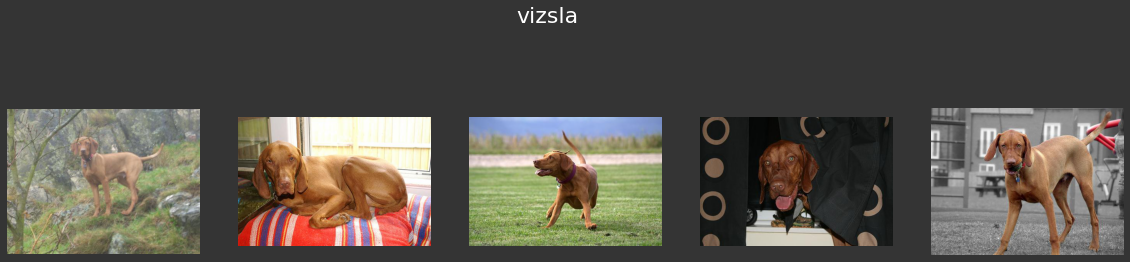

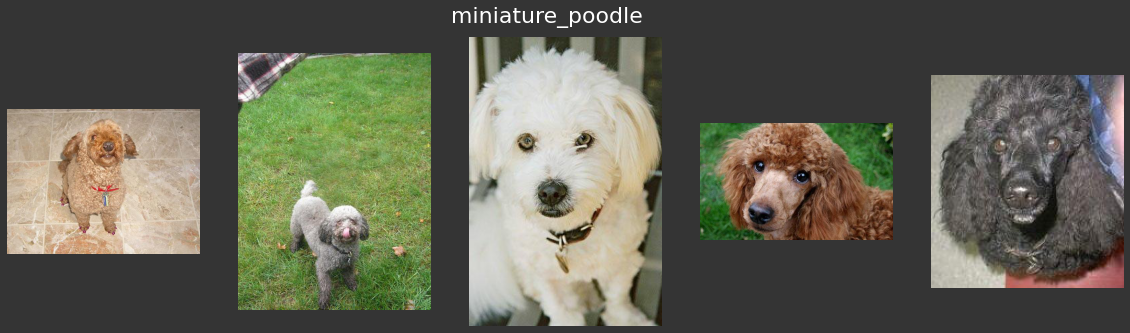

In [8]:
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)

One good practice over here is to start resizing our pictures as it will make the job of NN models easier

<h1><span style="color:#343434" id="ToC">Table of Content</span></h1>

1. [Image Preprocessing](#section_1)     
    1.1. [Quick overview of data](#section_1_1)     
    1.2. [Pictures resizing](#section_1_2)     
    1.3. [Chaging histograms of pictures](#section_1_3)      
    1.4. [Applying filters](#section_1_4)      
    1.5. [Data augmentation](#section_1_5)         
    
2. [CNN from scratch](#section_2)      
    2.1. [Preparing data](#section_2_1)      
    2.2. [Construction du modèle CNN](#section_2_2)      
    2.3. [Training and Evaluating CNN](#section_2_3)      

3. [Using pretrained models: VGG-16, Xception, Resnet50](#section_3)      
    3.1. [VGG-16](#section_3_1)      
    3.2. [Xception](#section_3_2)      
    3.3. [Resnet50](#section_3_3)      
    3.4. [Comparing results](#section_3_4)      
    
4. [Xception fine tuning](#section_4)    
5. [Xception on test set](#section_5)      

# Pictures resizing

In [9]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n02096585-Boston_bull/n02096585_2809.jpg")
img_test = cv.imread(img_test)

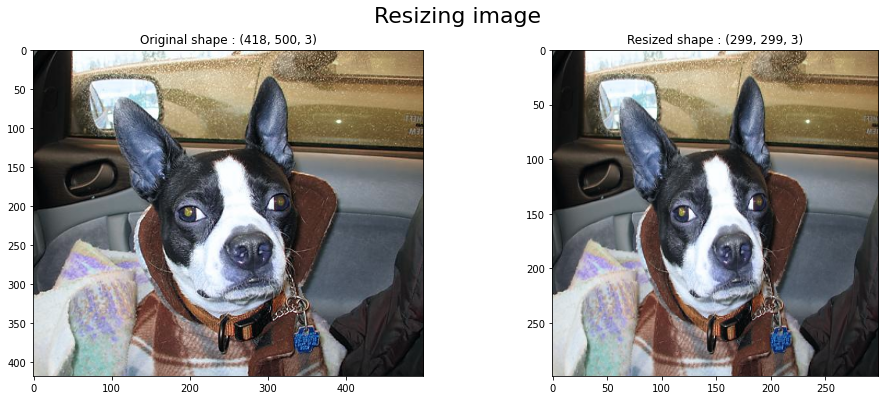

In [10]:
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

# Changing histograms of pictures

In [11]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

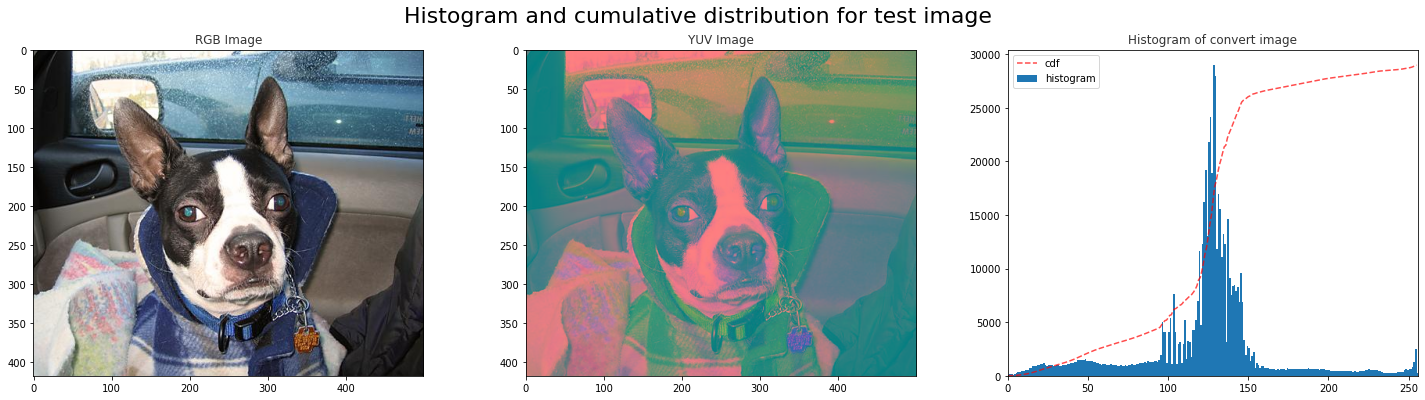

In [12]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

We can see from the chart on the right that the light is accumulated on the center of the picture, hence we need to compensate for that.

# Equalizing

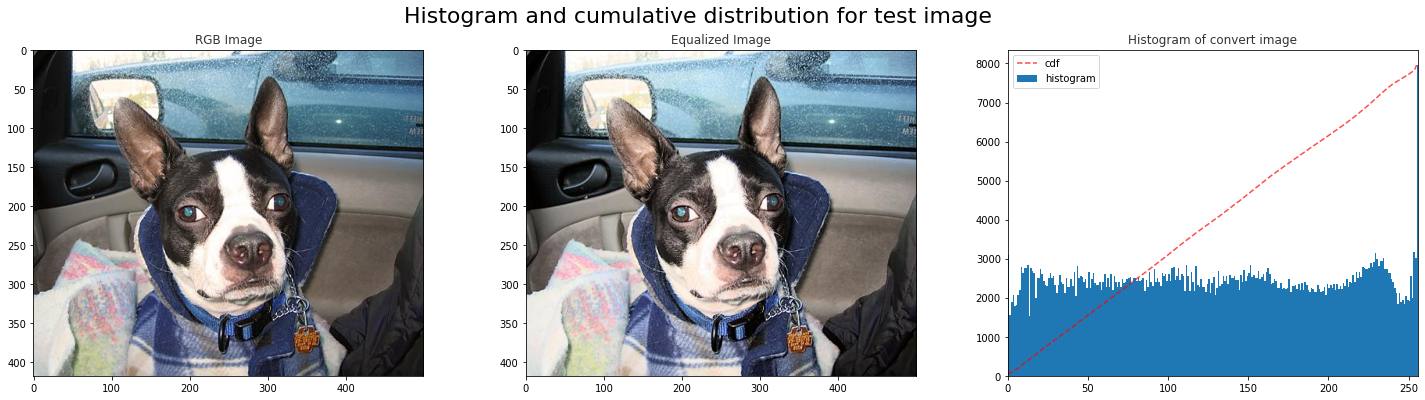

In [13]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

# Non Local means filter

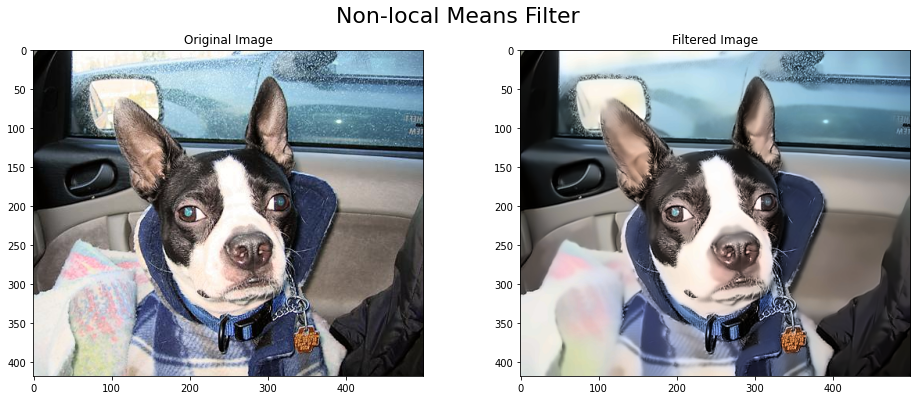

In [14]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

# Data Augmentation

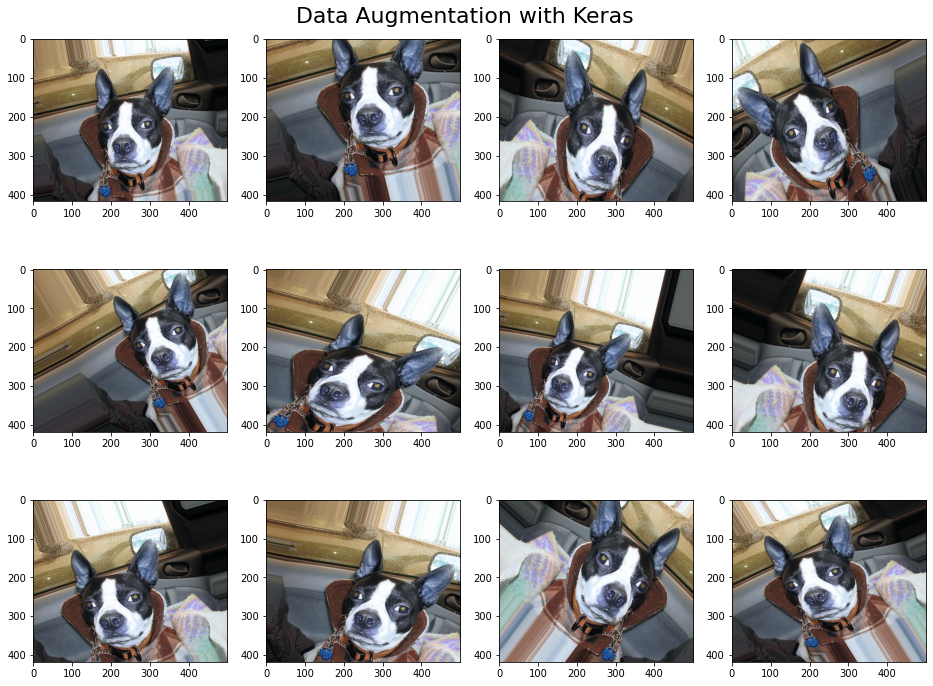

In [15]:
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()

In [16]:
custom_breed_list = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02105505-komondor',
    'n02107142-Doberman',
    'n02086240-Shih-Tzu',
    'n02111500-Great_Pyrenees',
    'n02108915-French_bulldog',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02111129-Leonberg',
    'n02106662-German_shepherd',
    'n02110185-Siberian_husky',
    'n02101006-Gordon_setter',
    'n02109961-Eskimo_dog',
    'n02088094-Afghan_hound',
    'n02106166-Border_collie',
    'n02106550-Rottweiler',
    'n02108422-bull_mastiff',
    'n02107574-Greater_Swiss_Mountain_dog',
]
#20 dog races selected in this project

In [17]:
# Define numbers of breeds to preprocess
num_breeds = len(custom_breed_list) 

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(custom_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 3442
Shape of images np.array : (3442, 299, 299, 3)
Total time : 856.73s


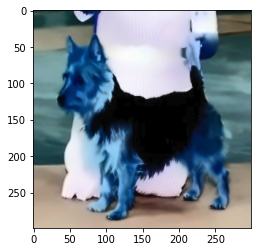

In [18]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[10]));

# Construction d'un CNN fait maison

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Preparing the data for the model

In [20]:
# The goal of the code below is to change the order of the data to avoid any abnormal patterns
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

In [21]:
# Change X type 
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [22]:
with open("./encoder.pickle", "wb") as f: 
    pickle.dump(encoder, f)

In [23]:
# Checking encoder created classes
print(encoder.classes_)

['Afghan_hound' 'Australian_terrier' 'Border_collie' 'Doberman'
 'English_setter' 'Eskimo_dog' 'French_bulldog' 'German_shepherd'
 'Gordon_setter' 'Great_Pyrenees' 'Greater_Swiss_Mountain_dog' 'Leonberg'
 'Rottweiler' 'Shih' 'Siberian_husky' 'Staffordshire_bullterrier'
 'bull_mastiff' 'cocker_spaniel' 'komondor']


In [24]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  2753
Test set size =  689


This is the last step of of the data prep. We will use Keras `ImageDataGenerator` to create batches of images to work with. These will
include Data Augmentation steps.

In [25]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

### Construction du modèle CNN

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

from tensorflow.keras import backend as K

We are going to use major layers to build our CNN from scratch:

`Convolution Layer`: It's goal is to find features in images receinved in input

`Pooling layers`: Its goal is to reduce dimension while preserving main features

`Correction Layer (ReLU)`: Replaces negative values with 0s. It is an activation layers

`Dense layers`: Takes a vector in input and returns another vector after applying a linear function, and eventually an activation function

`Dropout`: This is a regularization method, i.e. it's goal is to prevent overfitting. It does reset some proportion of weights to 0. 

In the code below, we implement the CNN using a micture of VGG-16 and AlexNet as source of inspiration. Note the follwing 
* We decide to keep (4,4) as stride, as changing it does not affect much performance of our model
* We decide to start with bigger filters (7,7) then gradually decrease size to (3,3) on last convolution layer to take into account the reduction of the dimension of our inputs

In [27]:
K.clear_session()

def custom_cnn_builder():
    """
    Raison d'être: Our builder function for our homemade CNN
    
    Args:
        None
    Retuns:
        The Newly built model
    """
    #First Convolution Layer
    inputs = Input(shape=(299,299,3))
    custom_CNN = Conv2D(filters=16,
                     kernel_size=(7,7), 
                     padding='same',
                     use_bias=False)(inputs)
    custom_CNN = BatchNormalization(axis=3, scale=False)(custom_CNN)
    custom_CNN = Activation('relu')(custom_CNN)
    custom_CNN = MaxPooling2D(pool_size=(4, 4),
                           strides=(4, 4),
                           padding='same')(custom_CNN)
    custom_CNN = Dropout(0.5)(custom_CNN)

    #Second Convolution Layer
    custom_CNN = Conv2D(filters=32,
                     kernel_size=(5,5), 
                     padding='same',
                     use_bias=False)(custom_CNN)
    custom_CNN = BatchNormalization(axis=3, scale=False)(custom_CNN)
    custom_CNN = Activation('relu')(custom_CNN)
    custom_CNN = MaxPooling2D(pool_size=(4, 4),
                           strides=(4, 4),
                           padding='same')(custom_CNN)
    custom_CNN = Dropout(0.5)(custom_CNN)

    #Third Convolution Layer
    custom_CNN = Conv2D(filters=64,
                     kernel_size=(3,3), 
                     padding='same',
                     use_bias=False)(custom_CNN)
    custom_CNN = BatchNormalization(axis=3, scale=False)(custom_CNN)
    custom_CNN = Activation('relu')(custom_CNN)
    custom_CNN = GlobalAveragePooling2D()(custom_CNN)

    #Fully Connected layer
    custom_CNN = Dense(128,activation='relu')(custom_CNN)
    custom_CNN = Dense(num_breeds, activation='softmax')(custom_CNN)

    my_custom_CNN = Model(inputs=inputs,
                           outputs=custom_CNN)
    
    return my_custom_CNN

In [28]:
custom_CNN = custom_cnn_builder()

[2022-01-03 14:50:00.391 tensorflow-2-3-gpu--ml-g4dn-xlarge-857ba94c8ff520cf618cce107153:280 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-03 14:50:00.444 tensorflow-2-3-gpu--ml-g4dn-xlarge-857ba94c8ff520cf618cce107153:280 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [29]:
custom_CNN.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 299, 299, 16)      2352      
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 299, 16)      48        
_________________________________________________________________
activation (Activation)      (None, 299, 299, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)       

In [30]:
# Compile the CNN Model
custom_CNN.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1])

In [31]:
BATCH_SIZE = 16
EPOCHS = 30

In [32]:
history = custom_CNN.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    steps_per_epoch=int(np.ceil(x_train.shape[0] / (2*BATCH_SIZE))),
    epochs=EPOCHS+20,
    verbose=2)

Epoch 1/50
87/87 - 29s - loss: 2.9180 - accuracy: 0.1168 - f1: 15.9228 - val_loss: 2.9760 - val_accuracy: 0.0782 - val_f1: 15.8494
Epoch 2/50
87/87 - 29s - loss: 2.8749 - accuracy: 0.1149 - f1: 15.4685 - val_loss: 3.0293 - val_accuracy: 0.0891 - val_f1: 13.2130
Epoch 3/50
87/87 - 28s - loss: 2.8359 - accuracy: 0.1348 - f1: 14.4949 - val_loss: 3.1498 - val_accuracy: 0.0800 - val_f1: 11.4337
Epoch 4/50
87/87 - 29s - loss: 2.8403 - accuracy: 0.1451 - f1: 15.0681 - val_loss: 2.9210 - val_accuracy: 0.0964 - val_f1: 15.7338
Epoch 5/50
87/87 - 29s - loss: 2.8333 - accuracy: 0.1327 - f1: 15.2540 - val_loss: 2.9061 - val_accuracy: 0.1164 - val_f1: 14.2118
Epoch 6/50
87/87 - 29s - loss: 2.8023 - accuracy: 0.1370 - f1: 15.0924 - val_loss: 3.1549 - val_accuracy: 0.0982 - val_f1: 12.3099
Epoch 7/50
87/87 - 29s - loss: 2.8100 - accuracy: 0.1377 - f1: 14.7139 - val_loss: 2.9725 - val_accuracy: 0.0836 - val_f1: 13.4861
Epoch 8/50
87/87 - 28s - loss: 2.7830 - accuracy: 0.1401 - f1: 14.5489 - val_loss: 

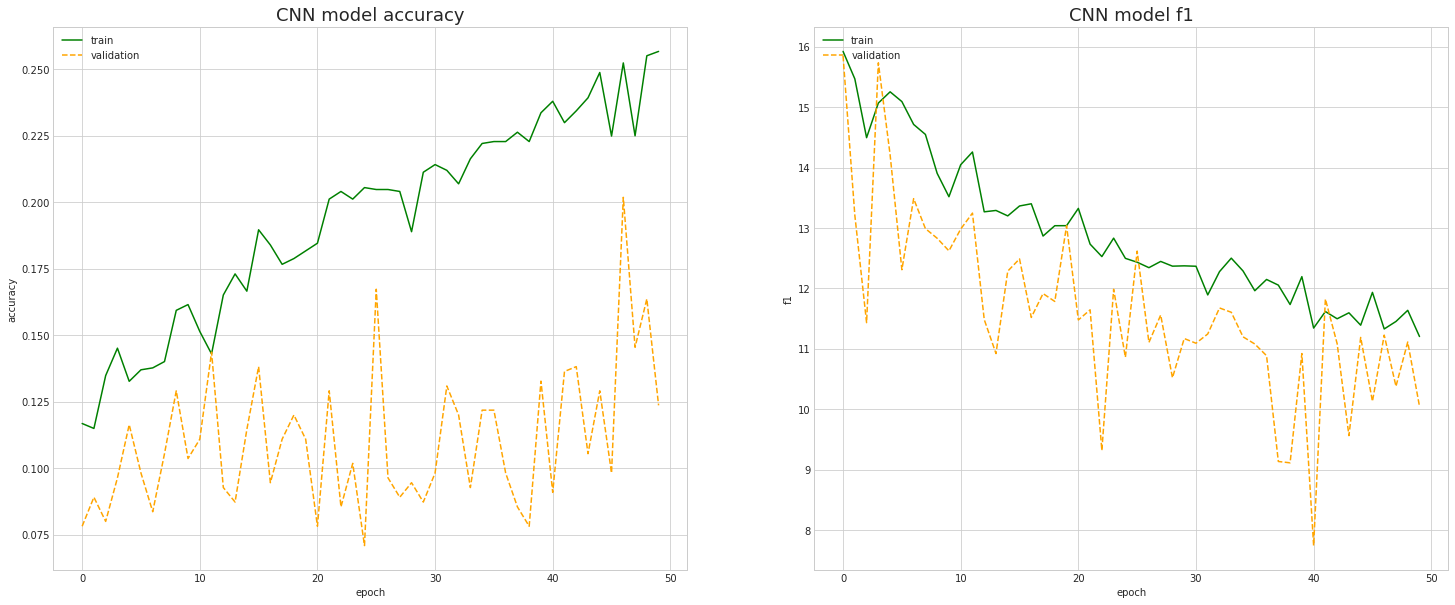

In [33]:
plot_history_scores(
    dict_history = history, 
    first_score = "accuracy", 
    second_score = "f1")

## Fine tuning our homemade CNN

In [34]:
def hpt_cnn_model_builder(hp):
    model = custom_cnn_builder()

    # Tune the learning rate and beta1 for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta1 = hp.Choice('beta_1', values=[0.9,0.95,0.99])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate,beta_1=hp_beta1),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy',f1])
    return model

In [35]:
tuner_cnn = kt.RandomSearch(hpt_cnn_model_builder,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir_custom_cnn',
    overwrite=True,
    project_name='custom_cnn')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Search best params
tuner_cnn.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    epochs=20,
    callbacks=[stop_early])

Trial 5 Complete [00h 12m 19s]
val_accuracy: 0.16545455157756805

Best val_accuracy So Far: 0.17272727191448212
Total elapsed time: 00h 53m 29s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [36]:
# Get the optimal hyperparameters
best_hps_custom_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Custom CNN Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps_custom_cnn.get('learning_rate')}.\n""")
print(f"""
Best beta_1 : {best_hps_custom_cnn.get('beta_1')}\n""")

--------------------------------------------------
Custom CNN Hyperparameters optimization :
--------------------------------------------------

Best learning rate : 0.001.


Best beta_1 : 0.9



In [37]:
hypermodel_custom_cnn = tuner_cnn.hypermodel.build(best_hps_custom_cnn)
history_custom_cnn = hypermodel_custom_cnn.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'), 
    epochs=EPOCHS+20,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    verbose=2)

Epoch 1/50
138/138 - 41s - loss: 2.9184 - accuracy: 0.1089 - f1: 15.6437 - val_loss: 3.0519 - val_accuracy: 0.0855 - val_f1: 13.7807
Epoch 2/50
138/138 - 40s - loss: 2.8523 - accuracy: 0.1357 - f1: 15.0543 - val_loss: 3.1234 - val_accuracy: 0.0855 - val_f1: 13.4704
Epoch 3/50
138/138 - 40s - loss: 2.8351 - accuracy: 0.1357 - f1: 14.8972 - val_loss: 3.0502 - val_accuracy: 0.1036 - val_f1: 12.3117
Epoch 4/50
138/138 - 41s - loss: 2.8094 - accuracy: 0.1457 - f1: 14.6115 - val_loss: 3.1274 - val_accuracy: 0.1127 - val_f1: 12.1996
Epoch 5/50
138/138 - 40s - loss: 2.7805 - accuracy: 0.1475 - f1: 14.5173 - val_loss: 2.9253 - val_accuracy: 0.1164 - val_f1: 14.9578
Epoch 6/50
138/138 - 40s - loss: 2.7623 - accuracy: 0.1530 - f1: 14.1842 - val_loss: 2.8689 - val_accuracy: 0.1182 - val_f1: 13.4488
Epoch 7/50
138/138 - 40s - loss: 2.7439 - accuracy: 0.1657 - f1: 13.8003 - val_loss: 3.2171 - val_accuracy: 0.0800 - val_f1: 10.7632
Epoch 8/50
138/138 - 41s - loss: 2.7182 - accuracy: 0.1625 - f1: 13.6

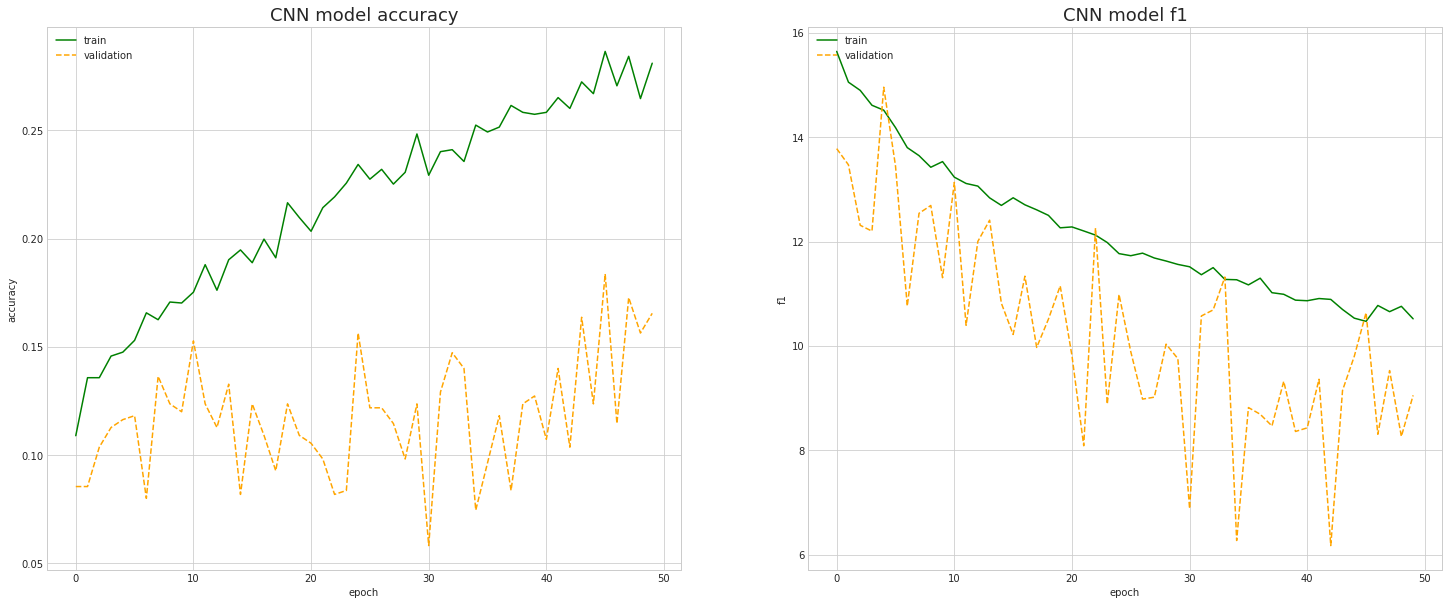

In [38]:
plot_history_scores(
    dict_history = history_custom_cnn, 
    first_score = "accuracy", 
    second_score = "f1")

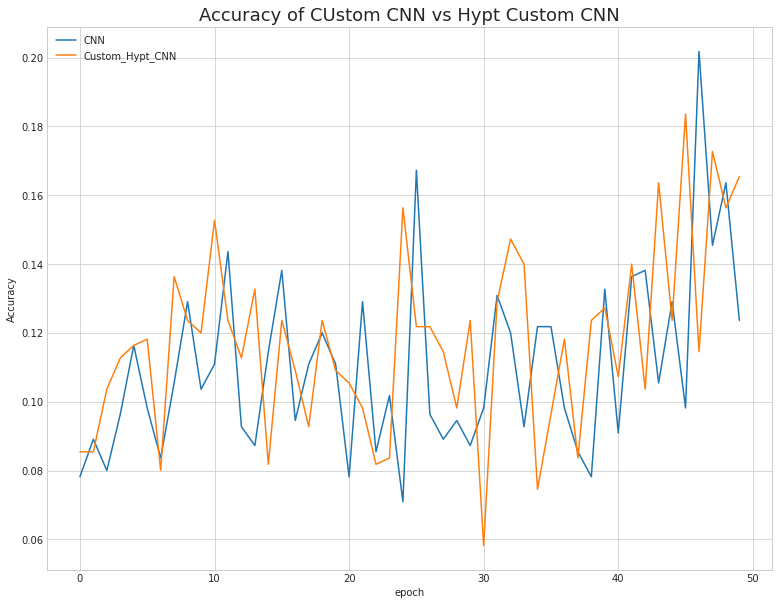

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['val_accuracy'],
             label='CNN')
    plt.plot(history_custom_cnn.history['val_accuracy'],
             label='Custom_Hypt_CNN')
    plt.title('Accuracy of CUstom CNN vs Hypt Custom CNN',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

# Using pre-trained models: VGG-16, Xception and ResNet50 with ImageNet

### VGG-16

In [40]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [41]:
K.clear_session()

base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(299,299,3))

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [42]:
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_breeds, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)      

In [43]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy",f1])

In [44]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

In [45]:
history_vgg16 = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    steps_per_epoch=int(np.ceil(x_train.shape[0] / (2*BATCH_SIZE))),
    epochs=EPOCHS,
    verbose=2)

Epoch 1/30
87/87 - 35s - loss: 7.0706 - accuracy: 0.1355 - f1: 2.4247 - val_loss: 22.1989 - val_accuracy: 0.0891 - val_f1: 1.2865
Epoch 2/30
87/87 - 30s - loss: 5.2675 - accuracy: 0.1753 - f1: 2.6213 - val_loss: 8.8504 - val_accuracy: 0.1509 - val_f1: 1.8163
Epoch 3/30
87/87 - 29s - loss: 4.4073 - accuracy: 0.2091 - f1: 2.7956 - val_loss: 5.1323 - val_accuracy: 0.2509 - val_f1: 2.4122
Epoch 4/30
87/87 - 30s - loss: 3.9580 - accuracy: 0.2257 - f1: 2.8712 - val_loss: 4.6864 - val_accuracy: 0.2364 - val_f1: 2.6107
Epoch 5/30
87/87 - 29s - loss: 3.8679 - accuracy: 0.2372 - f1: 2.9209 - val_loss: 4.0208 - val_accuracy: 0.2491 - val_f1: 2.7100
Epoch 6/30
87/87 - 29s - loss: 3.8435 - accuracy: 0.2422 - f1: 3.0656 - val_loss: 3.9607 - val_accuracy: 0.2509 - val_f1: 2.6505
Epoch 7/30
87/87 - 29s - loss: 3.6992 - accuracy: 0.2486 - f1: 3.0895 - val_loss: 3.9770 - val_accuracy: 0.2782 - val_f1: 2.5562
Epoch 8/30
87/87 - 29s - loss: 3.5627 - accuracy: 0.2437 - f1: 3.1308 - val_loss: 3.4982 - val_a

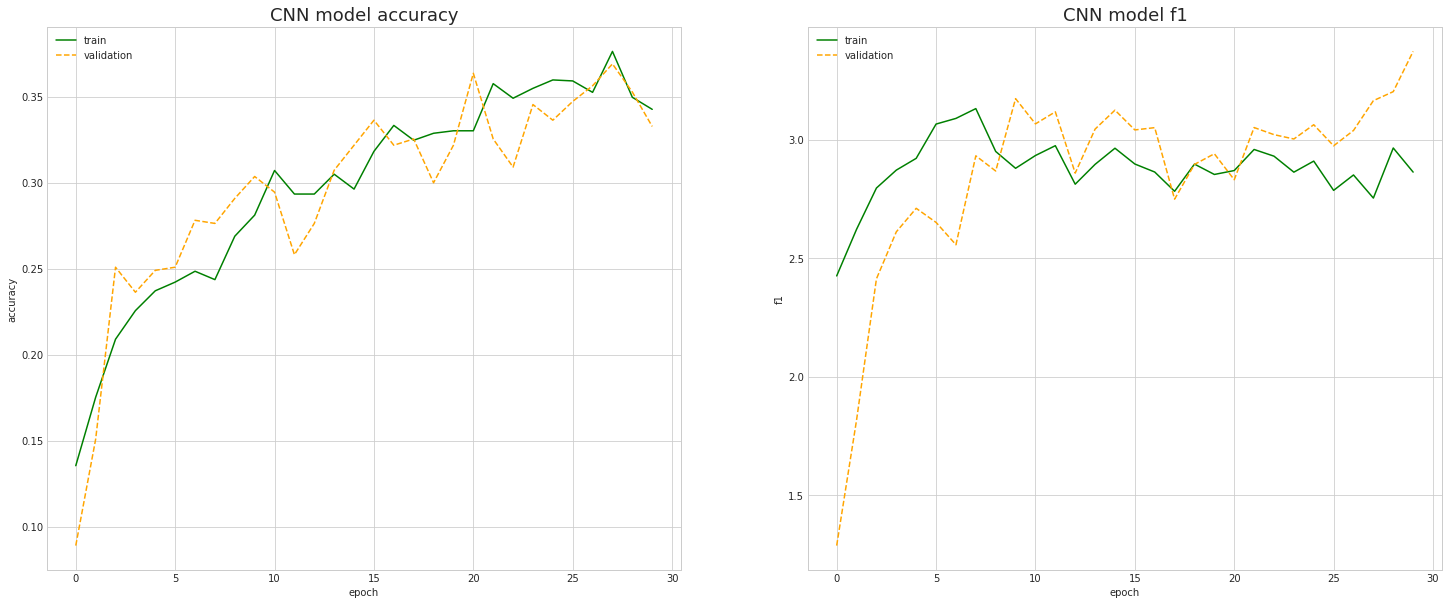

In [46]:
plot_history_scores(
    dict_history = history_vgg16, 
    first_score = "accuracy", 
    second_score = "f1")

### Xception

In [47]:
from tensorflow.keras.applications.xception import Xception

In [48]:
K.clear_session()

xception_model = Xception(weights="imagenet",
                   include_top=False,
                   pooling='avg',
                   input_shape=(299,299,3))

for layer in xception_model.layers:
    layer.trainable = False

In [49]:
# Add new fully-connected layers
base_xception = xception_model.output
base_xception = Dense(128, activation='relu')(base_xception)
base_xception = Dropout(0.2)(base_xception)
# Output : new classifier
predictions = Dense(num_breeds, activation='softmax')(base_xception)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)

In [50]:
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1])

In [51]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [52]:
len(xception_model.layers)

133

In [53]:
my_xcept_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [54]:
## Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [55]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    steps_per_epoch=int(np.ceil(x_train.shape[0] / (2*BATCH_SIZE))),
    epochs=EPOCHS,
    verbose=2)

Epoch 1/30
87/87 - 30s - loss: 1.6749 - accuracy: 0.5223 - f1: 7.6336 - val_loss: 0.9941 - val_accuracy: 0.6855 - val_f1: 3.7388
Epoch 2/30
87/87 - 29s - loss: 0.9110 - accuracy: 0.7066 - f1: 3.0481 - val_loss: 0.8654 - val_accuracy: 0.7345 - val_f1: 3.0371
Epoch 3/30
87/87 - 29s - loss: 0.7671 - accuracy: 0.7664 - f1: 2.6818 - val_loss: 0.7354 - val_accuracy: 0.7509 - val_f1: 2.5929
Epoch 4/30
87/87 - 29s - loss: 0.7457 - accuracy: 0.7513 - f1: 2.5212 - val_loss: 0.7188 - val_accuracy: 0.7327 - val_f1: 2.5175
Epoch 5/30
87/87 - 29s - loss: 0.7035 - accuracy: 0.7622 - f1: 2.3432 - val_loss: 0.6631 - val_accuracy: 0.7727 - val_f1: 2.2049
Epoch 6/30
87/87 - 29s - loss: 0.6323 - accuracy: 0.7895 - f1: 2.3040 - val_loss: 0.7210 - val_accuracy: 0.7655 - val_f1: 2.2191
Epoch 7/30
87/87 - 29s - loss: 0.6144 - accuracy: 0.7938 - f1: 2.1768 - val_loss: 0.6786 - val_accuracy: 0.7673 - val_f1: 2.0534
Epoch 8/30
87/87 - 29s - loss: 0.6113 - accuracy: 0.7902 - f1: 2.1281 - val_loss: 0.6413 - val_ac

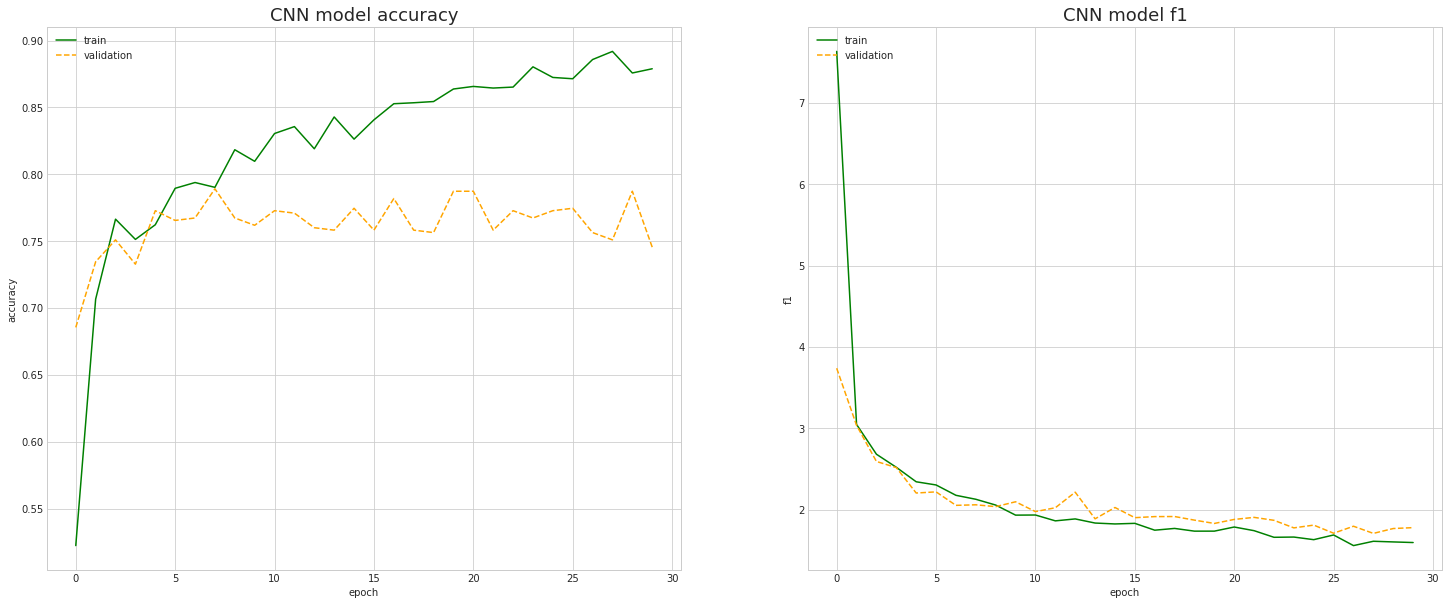

In [56]:
plot_history_scores(
    dict_history = history_xcept, 
    first_score = "accuracy", 
    second_score = "f1")

### ResNet 50

In [57]:
from tensorflow.keras.applications import ResNet50

In [58]:
K.clear_session()
resnet_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False

In [59]:
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.5)(rn_base_output)
# Output : new classifier
rn_predictions = Dense(num_breeds, activation='softmax')(rn_base_output)

In [60]:
# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1])

In [61]:
# Data generator on train set with Data Augmentation
# and preprocess_input Resnet
# Validation set is define here
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#For validation and test, just rescale
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [62]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    steps_per_epoch=int(np.ceil(x_train.shape[0] / (2*BATCH_SIZE))),
    epochs=EPOCHS,
    verbose=2)

Epoch 1/30
87/87 - 30s - loss: 2.8378 - accuracy: 0.1485 - f1: 13.2096 - val_loss: 2.4625 - val_accuracy: 0.2564 - val_f1: 11.7781
Epoch 2/30
87/87 - 29s - loss: 2.5158 - accuracy: 0.2069 - f1: 11.5054 - val_loss: 2.2628 - val_accuracy: 0.2673 - val_f1: 10.3570
Epoch 3/30
87/87 - 29s - loss: 2.2323 - accuracy: 0.2913 - f1: 9.8783 - val_loss: 1.8025 - val_accuracy: 0.4782 - val_f1: 9.0509
Epoch 4/30
87/87 - 29s - loss: 1.9948 - accuracy: 0.3634 - f1: 8.2847 - val_loss: 1.6916 - val_accuracy: 0.5273 - val_f1: 8.8773
Epoch 5/30
87/87 - 29s - loss: 1.9201 - accuracy: 0.3843 - f1: 7.7798 - val_loss: 1.5727 - val_accuracy: 0.5582 - val_f1: 7.6370
Epoch 6/30
87/87 - 29s - loss: 1.7903 - accuracy: 0.4195 - f1: 7.0191 - val_loss: 1.4221 - val_accuracy: 0.5836 - val_f1: 6.9802
Epoch 7/30
87/87 - 29s - loss: 1.6957 - accuracy: 0.4405 - f1: 6.5923 - val_loss: 1.3516 - val_accuracy: 0.5964 - val_f1: 6.7358
Epoch 8/30
87/87 - 29s - loss: 1.6307 - accuracy: 0.4621 - f1: 6.2404 - val_loss: 1.2981 - va

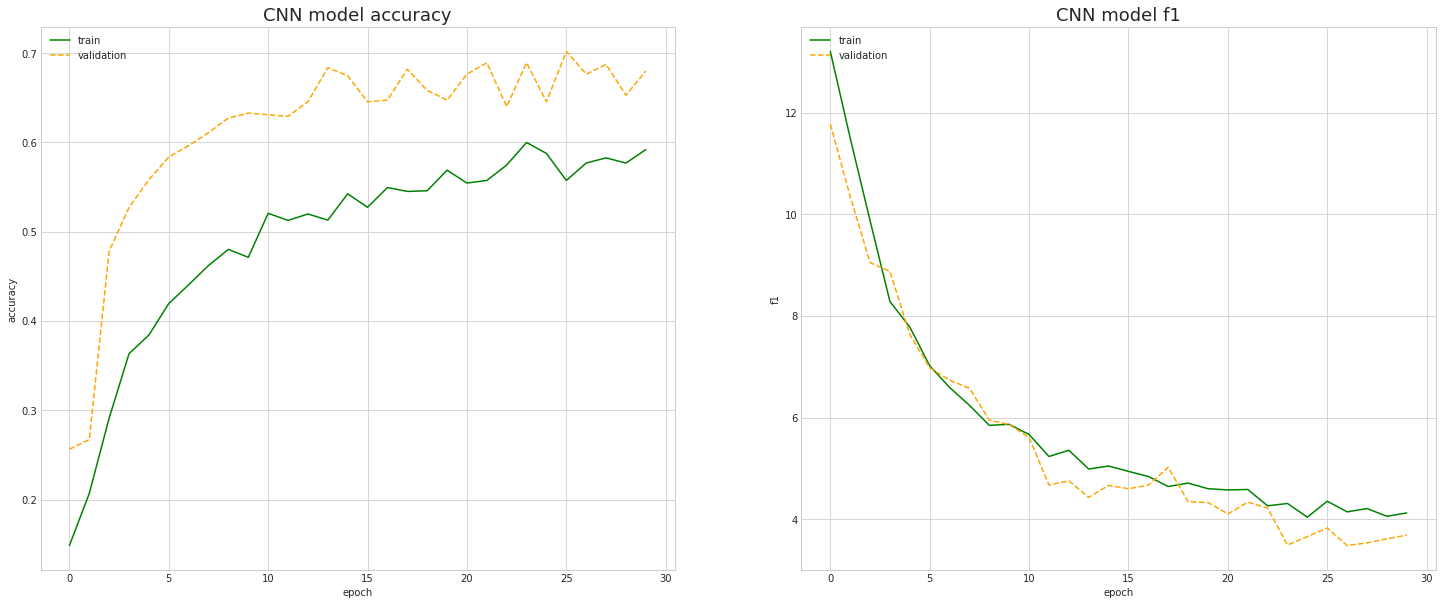

In [63]:
plot_history_scores(
    dict_history = history_resnet, 
    first_score = "accuracy", 
    second_score = "f1")

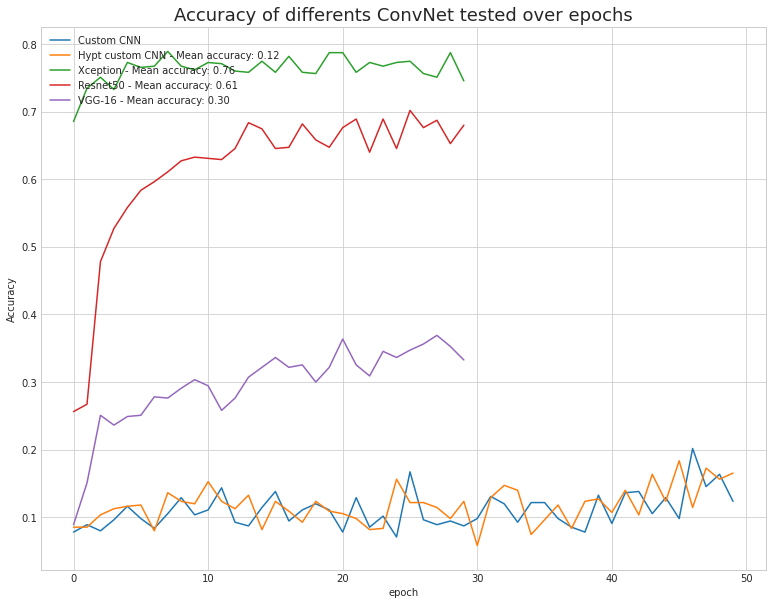

In [64]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['val_accuracy'],
             label='Custom CNN')
    plt.plot(history_custom_cnn.history['val_accuracy'],
             label='Hypt custom CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history_custom_cnn.history['val_accuracy'])))
    plt.plot(history_xcept.history['val_accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['val_accuracy'])))
    plt.plot(history_resnet.history['val_accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['val_accuracy'])))
    plt.plot(history_vgg16.history['val_accuracy'],
             label='VGG-16 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_vgg16.history['val_accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

## Fine tuning hyperparameters for Xception

We decided to keep the Xception model for the rest of this project as it gives the best performance on our chosen metrics

### Finetuning the Fully connected layers

We will use `kerastuner` to fine tune the connected layer we added to Xception

In [65]:
def model_builder(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299,299,3))
    
    for layer in xception_model.layers:
        layer.trainable = False
    
    base_output = xception_model.output
    
    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    base_output = Dense(units=hp_units, 
                        activation='relu')(base_output)
    
    base_output = Dropout(0.5)(base_output)
    
    # Output : new classifier
    predictions = Dense(num_breeds, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
    
    # Tune learning rate
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])
    
    hp_beta1 = hp.Choice(
        name='beta_1', 
        values=[0.9,0.95,0.99])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta1),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1])
    
    return my_xcept_model

In [67]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    overwrite=True,
    project_name='Xcept_kt'
    )

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Search best params
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    epochs=20,
    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Xception Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.\n
Best beta_1 : {best_hps.get('beta_1')}.
""")

Trial 5 Complete [00h 07m 04s]
val_accuracy: 0.7854545712471008

Best val_accuracy So Far: 0.7927272915840149
Total elapsed time: 00h 48m 40s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


--------------------------------------------------
Xception Hyperparameters optimization :
--------------------------------------------------

Best learning rate : 0.001.

Best Dense units : 128.

Best beta_1 : 0.95.



Now that we have the optimal parameters, we can now retrain the model to have the fully connected layer optimised

In [68]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='training'), 
    epochs=EPOCHS,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        subset='validation'),
    verbose=2)
hypermodel.save('xception_hypermodel.h5')
print("Model saved")

Epoch 1/30
138/138 - 42s - loss: 1.9371 - accuracy: 0.4462 - f1: 8.5733 - val_loss: 1.1009 - val_accuracy: 0.6982 - val_f1: 4.9230
Epoch 2/30
138/138 - 41s - loss: 1.1373 - accuracy: 0.6577 - f1: 4.0719 - val_loss: 0.8111 - val_accuracy: 0.7400 - val_f1: 3.1619
Epoch 3/30
138/138 - 41s - loss: 1.0023 - accuracy: 0.6818 - f1: 3.3819 - val_loss: 0.7857 - val_accuracy: 0.7418 - val_f1: 2.9735
Epoch 4/30
138/138 - 41s - loss: 0.9129 - accuracy: 0.7140 - f1: 3.0138 - val_loss: 0.6944 - val_accuracy: 0.7436 - val_f1: 2.6192
Epoch 5/30
138/138 - 41s - loss: 0.8320 - accuracy: 0.7335 - f1: 2.7446 - val_loss: 0.7208 - val_accuracy: 0.7618 - val_f1: 2.8167
Epoch 6/30
138/138 - 41s - loss: 0.7864 - accuracy: 0.7463 - f1: 2.7840 - val_loss: 0.7100 - val_accuracy: 0.7509 - val_f1: 2.4672
Epoch 7/30
138/138 - 41s - loss: 0.7383 - accuracy: 0.7581 - f1: 2.5194 - val_loss: 0.7044 - val_accuracy: 0.7527 - val_f1: 2.4069
Epoch 8/30
138/138 - 41s - loss: 0.7523 - accuracy: 0.7631 - f1: 2.5563 - val_loss:

### Finetuning blocks inside Xception

Remember at this point we only optimised the layers "outside" of Xception. Hence now we would like to re-train only some parts of the blocks of Xception

Xception has 3 flows:
* Entry flow
* Middle flow 
* Exit flow 

We are only going to `retrain the exit flow` with the previous newly optimised fully connected layer parameters. That is the reason why we only unfrezze the layers after the 115th layer

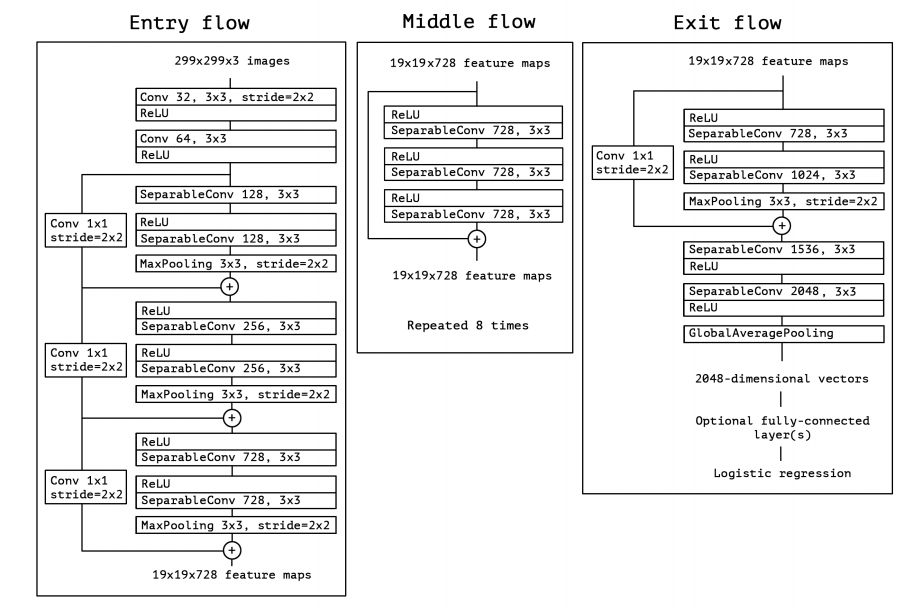

In [69]:
def xception_fine_tune(nb_layers):
    """
    Raison d'être: Training some parts only of model and returning the trained model
    Args: 
        nb_layer: number of layers NOT to be trained
    Returns:
        hypermodel_t: the newly trained model
    """
    # Load the pre trained model
    hypermodel_t = load_model('./xception_hypermodel.h5', custom_objects={"f1": f1})
    
    # re train the last layers
    for i, layer in enumerate(hypermodel_t.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compile model
    hypermodel_t.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1])
    
    return hypermodel_t

In [70]:
# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Dont train the 115 first layers. Last layer excluding the exit flow is layer 115. Then we get in the exit flow. 
my_tuned_xcept_model = xception_fine_tune(115)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=False,
        subset='training'), 
    epochs=EPOCHS,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

my_tuned_xcept_model.save('my_tuned_xcept_model.h5')
print("Tuned Model saved")

Epoch 1/30
138/138 - 42s - loss: 1.1300 - accuracy: 0.6686 - f1: 3.2206 - val_loss: 1.0827 - val_accuracy: 0.6855 - val_f1: 1.9214
Epoch 2/30
138/138 - 42s - loss: 0.9153 - accuracy: 0.7177 - f1: 2.5954 - val_loss: 0.8688 - val_accuracy: 0.7400 - val_f1: 1.8888
Epoch 3/30
138/138 - 42s - loss: 0.7203 - accuracy: 0.7771 - f1: 2.2644 - val_loss: 0.8232 - val_accuracy: 0.7400 - val_f1: 2.0068
Epoch 4/30
138/138 - 41s - loss: 0.6238 - accuracy: 0.8062 - f1: 2.0660 - val_loss: 1.1217 - val_accuracy: 0.7218 - val_f1: 1.6727
Epoch 5/30
138/138 - 42s - loss: 0.5417 - accuracy: 0.8298 - f1: 1.8583 - val_loss: 1.0613 - val_accuracy: 0.7600 - val_f1: 1.5788
Epoch 6/30
138/138 - 42s - loss: 0.4713 - accuracy: 0.8466 - f1: 1.7480 - val_loss: 1.3419 - val_accuracy: 0.7218 - val_f1: 1.6297
Epoch 7/30
138/138 - 42s - loss: 0.4530 - accuracy: 0.8584 - f1: 1.7060 - val_loss: 0.6916 - val_accuracy: 0.8055 - val_f1: 1.5642
Epoch 8/30
138/138 - 42s - loss: 0.3869 - accuracy: 0.8747 - f1: 1.5591 - val_loss:

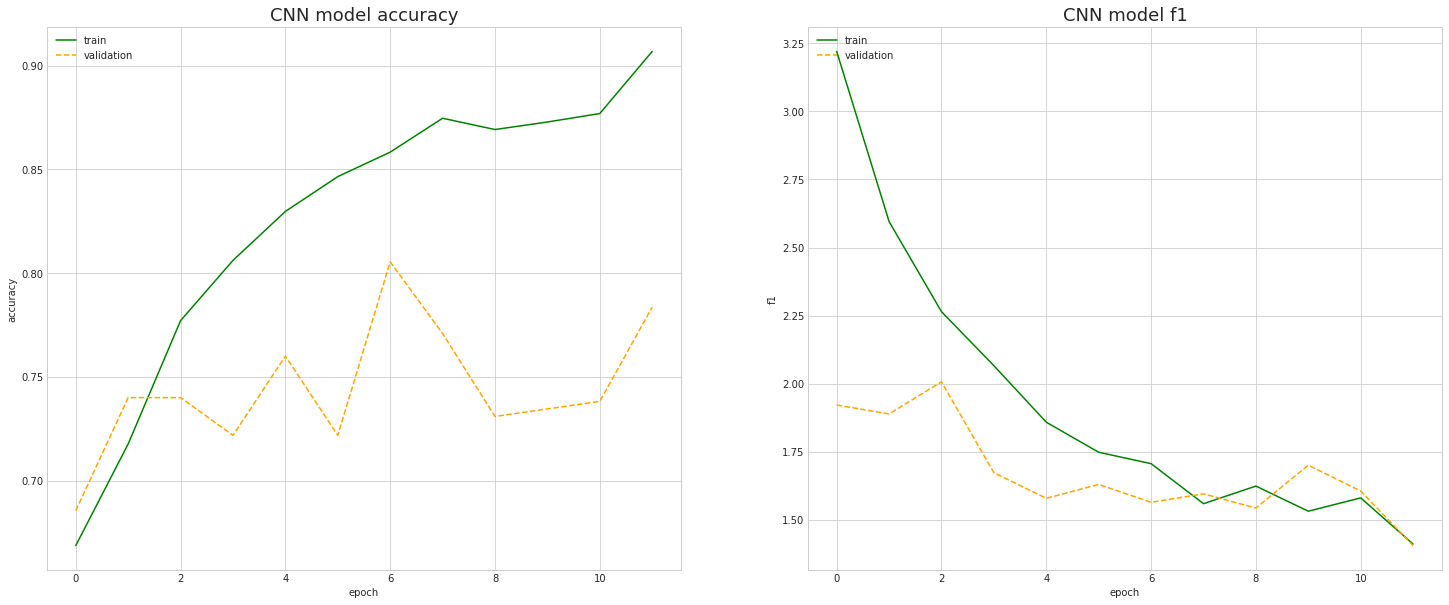

In [71]:
plot_history_scores(
    dict_history = fine_tuned_history, 
    first_score = "accuracy", 
    second_score = "f1")

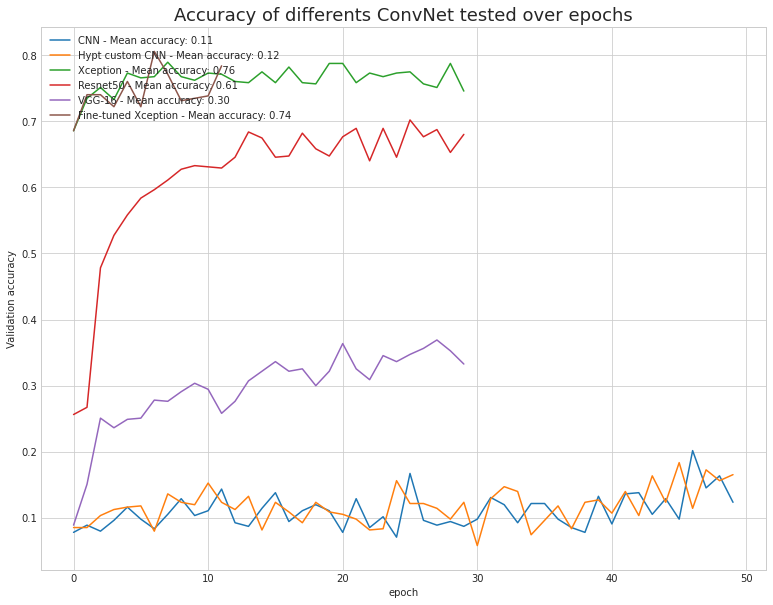

In [72]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['val_accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['val_accuracy'])))
    plt.plot(history_custom_cnn.history['val_accuracy'],
             label='Hypt custom CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history_custom_cnn.history['val_accuracy'])))
    plt.plot(history_xcept.history['val_accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['val_accuracy'])))
    plt.plot(history_resnet.history['val_accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['val_accuracy'])))
    plt.plot(history_vgg16.history['val_accuracy'],
             label='VGG-16 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_vgg16.history['val_accuracy'])))
    plt.plot(fine_tuned_history.history['val_accuracy'],
             label='Fine-tuned Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(fine_tuned_history.history['val_accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Validation accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

# Testing our finetuned model on Test set

In [73]:
# Model evaluation on test set
xception_eval = fine_tuned_history.model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False),
    verbose=1)
print("-" * 50)
print("Xception model evaluation :")
print("-" * 50)
print('Test Loss: {:.3f}'.format(xception_eval[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval[1]))
print('Test F1 score: {:.3f}'.format(xception_eval[2]))

44/44 [==============================] - 5s 104ms/step - loss: 0.7087 - accuracy: 0.8113 - f1: 1.3537
--------------------------------------------------
Xception model evaluation :
--------------------------------------------------
Test Loss: 0.709
Test Accuracy: 0.811
Test F1 score: 1.354


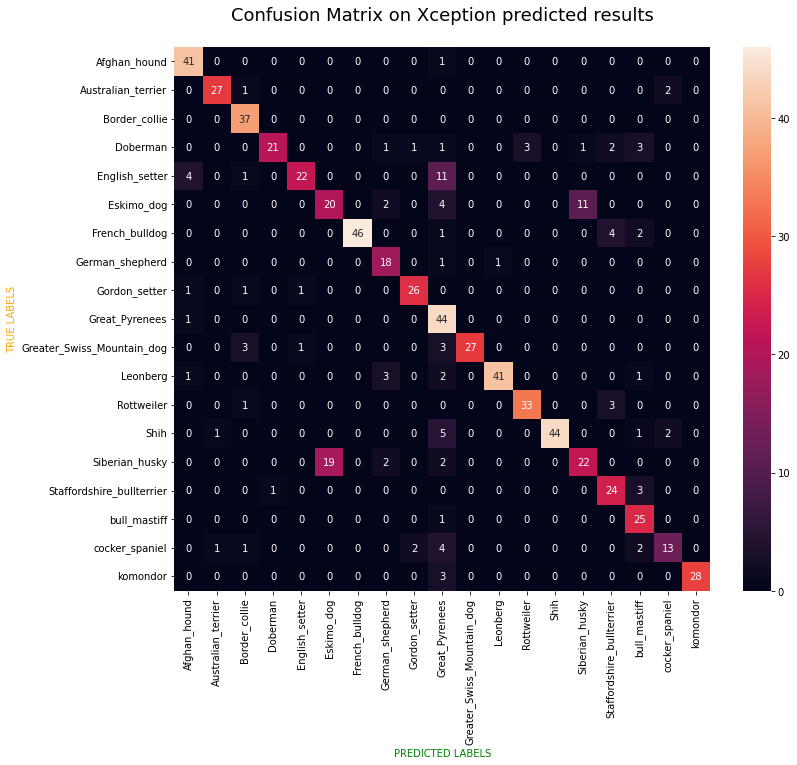

In [74]:
# Make predictions
Y_pred = fine_tuned_history.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

# Inverse transform of encoding
y_pred_s = encoder.inverse_transform(y_pred)
y_test_s = encoder.inverse_transform(y_test)

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("PREDICTED LABELS", color="g")
ax.set_ylabel("TRUE LABELS", color="orange")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception predicted results\n",
          fontsize=18)
plt.show()

In [75]:
# Classification report
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(y_test_s))))

                            precision    recall  f1-score   support

              Afghan_hound       0.85      0.98      0.91        42
        Australian_terrier       0.93      0.90      0.92        30
             Border_collie       0.82      1.00      0.90        37
                  Doberman       0.95      0.64      0.76        33
            English_setter       0.92      0.58      0.71        38
                Eskimo_dog       0.51      0.54      0.53        37
            French_bulldog       1.00      0.87      0.93        53
           German_shepherd       0.69      0.90      0.78        20
             Gordon_setter       0.90      0.90      0.90        29
            Great_Pyrenees       0.53      0.98      0.69        45
Greater_Swiss_Mountain_dog       1.00      0.79      0.89        34
                  Leonberg       0.98      0.85      0.91        48
                Rottweiler       0.92      0.89      0.90        37
                      Shih       1.00      0.83

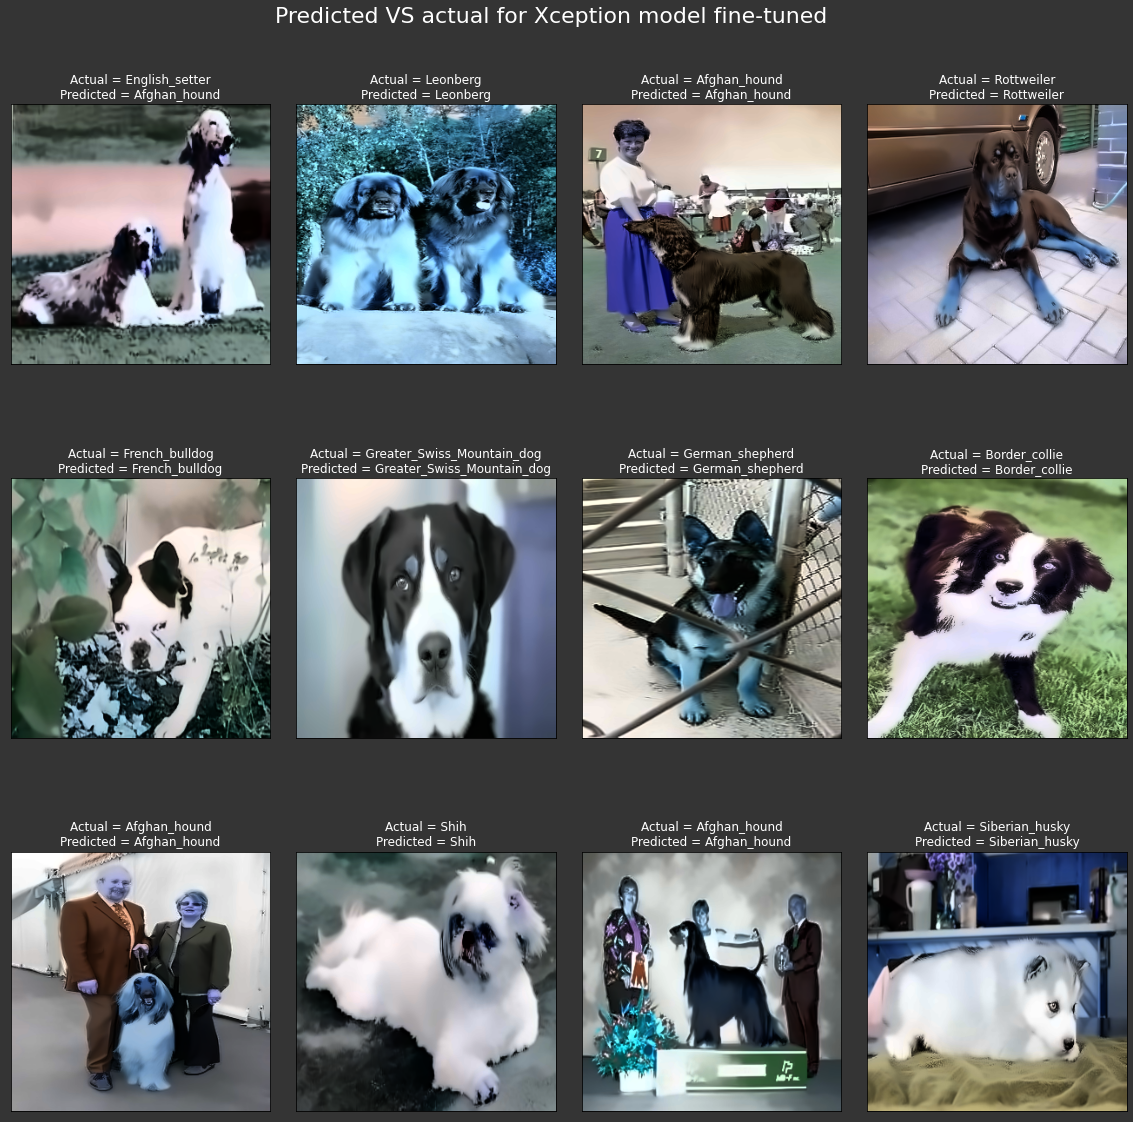

In [76]:
fig = plt.figure(1, figsize=(20,20))
fig.patch.set_facecolor('#343434')
plt.suptitle("Predicted VS actual for Xception model fine-tuned",
             y=.92, fontsize=22,
             color="white")

n = 0

for i in range(12):
    n+=1
    r = int(np.random.randint(0, x_test.shape[0], 1))
    plt.subplot(3,4,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(image.array_to_img(x_test[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_test_s[r] , y_pred_s[r]),
              color="white")
    plt.xticks([]) , plt.yticks([])
    
plt.show()